## Oddity Home Assignment- Shua Friedman

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

In [76]:
data = pd.read_csv('data.csv')

### Data Exploration

In [77]:
data.head()

,id,email_campaign_variant,purchased,order_refunded,refund_reason,contacted_customer_support,quiz__top_skin_concerns,quiz__skin_type,quiz__makeup_usage_amount,quiz__makeup_how_comfortable,quiz__age,quiz__skin_sensitivity,quiz__acne_breakout_freq,quiz__acne_num_pimples,utm_source,country
0,10f3a1813ca1232b91675b4c65c13bba969b71e9096b1a...,variant2,False,NaN,NaN,NaN,"Acne, Wrinkles, Clogged pores",Combination,A decent amount,Somewhat,41-55,Not at all,Rarely,None,tiktok.com,Canada
1,3c04ee164dca33572b9d0df8ebe19e1d907e3bf8108e44...,variant1,False,NaN,NaN,NaN,"Acne, Wrinkles, Redness",Combination,A little,Somewhat,21-30,A little,Daily,1-3,facebook.com,Canada
2,9d6f710f62f93b6ca99727af34b4d94340e48f521d830b...,old_email,True,False,NaN,False,"Dark spots or uneven tone, Clogged pores",Oily,None,NaN,31-40,A little,Rarely,None,facebook.com,United Kingdom
3,5b92696629664dcb7a910c8370f89b0123cf40760677c1...,old_email,False,NaN,NaN,NaN,Acne,Combination,Full coverage,Very,Above 55,A little,Rarely,1-3,facebook.com,Canada
4,60ac9903a106b2ae54150ca74adb641be8656b7c65eb20...,variant1,False,NaN,NaN,NaN,"Acne, Dark spots or uneven tone",Combination,Full coverage,Somewhat,21-30,A little,Monthly,None,tiktok.com,United Kingdom


<AxesSubplot: >

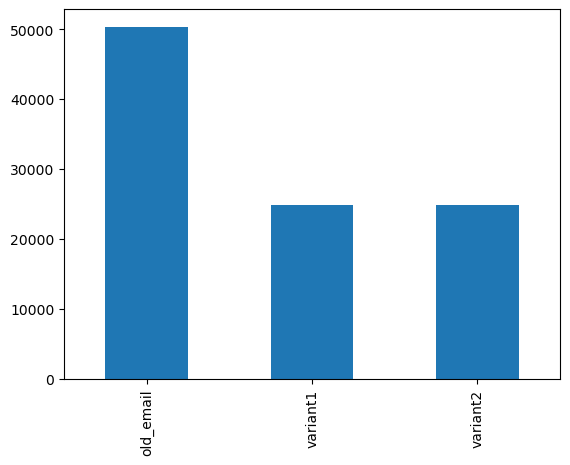

In [78]:
data.email_campaign_variant.value_counts().plot(kind='bar')

<AxesSubplot: >

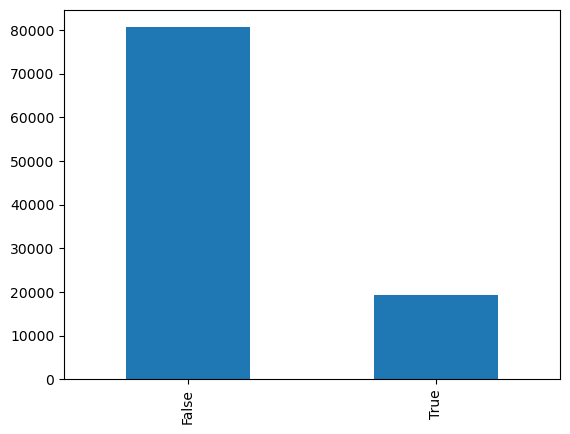

In [79]:
data.purchased.value_counts().plot(kind='bar')

In [80]:
#ratio of purchased to not purchased
data.purchased.value_counts() / data.purchased.count()

False    0.80583
True     0.19417
Name: purchased, dtype: float64

We can see here that there is a decent target imbalance. Will likely have to compensate for this in the modeling.

Null values:

In [81]:
data.isnull().sum().sort_values(ascending=False)/len(data)

refund_reason                   0.94941
order_refunded                  0.80583
contacted_customer_support      0.80583
quiz__makeup_how_comfortable    0.11750
quiz__age                       0.01397
utm_source                      0.00127
id                              0.00000
email_campaign_variant          0.00000
purchased                       0.00000
quiz__top_skin_concerns         0.00000
quiz__skin_type                 0.00000
quiz__makeup_usage_amount       0.00000
quiz__skin_sensitivity          0.00000
quiz__acne_breakout_freq        0.00000
quiz__acne_num_pimples          0.00000
country                         0.00000
dtype: float64

Intentional (meaningful) Null values: refund reason

Unintentional (non-meaningful) null values: order refunded. contacted customer support, makeup_how_uncomfortable, quiz_age, utm_source.


Regarding the refund columns: Since these columns are only relevant *After* purchase time, and purchase is what we are trying to predict, we can't use these features, as this would be a data leak

In [82]:
df = data.copy()
df.drop('refund_reason', axis=1, inplace=True)
df.drop('order_refunded', axis=1, inplace=True)
df.drop('contacted_customer_support', axis=1, inplace=True)

In [83]:
#order refunded. contacted customer support, makeup_how_uncomfortable, quiz_age, utm_source, make null values = to mode of column
# df.order_refunded.fillna(df.order_refunded.mode()[0], inplace=True)
# df.contacted_customer_support.fillna(df.contacted_customer_support.mode()[0], inplace=True)
df.quiz__makeup_how_comfortable.fillna(df.quiz__makeup_how_comfortable.mode()[0], inplace=True)
df.quiz__age.fillna(df.quiz__age.mode()[0], inplace=True)
df.utm_source.fillna(df.utm_source.mode()[0], inplace=True)


In [84]:
df.quiz__top_skin_concerns.value_counts()

Dark spots or uneven tone, Wrinkles, Redness          8475
Acne, Wrinkles, Redness                               8002
Acne, Wrinkles, Clogged pores                         7682
Wrinkles, Clogged pores, Redness                      5843
Dark spots or uneven tone, Wrinkles, Clogged pores    5413
Acne, Clogged pores, Redness                          5385
Acne, Dark spots or uneven tone, Redness              5309
Acne, Dark spots or uneven tone, Clogged pores        4441
Dark spots or uneven tone, Clogged pores              4384
Dark spots or uneven tone, Clogged pores, Redness     3620
Clogged pores, Redness                                3572
Dark spots or uneven tone, Wrinkles                   3526
Acne, Wrinkles                                        3493
Acne, Dark spots or uneven tone                       3485
Acne, Dark spots or uneven tone, Wrinkles             3227
Dark spots or uneven tone, Redness                    2803
Clogged pores                                         26

Lets try grouping some of this values, as one hot encoding will create a bit of a sparse dataset
We will createanew column for each of ['Acne', 'Wrinkles', 'Clogged pores', 'Redness', 'Dark spots or uneven tone']. If the value is in the row, we will mark that column with a 1 for that row, else 0

In [85]:
def check_for_str(str, row):
    if str in row:
        return 1
    else:
        return 0

df['quiz__Acne'] = df.quiz__top_skin_concerns.apply(lambda x: check_for_str('Acne', x))
df['quiz__Wrinkles'] = df.quiz__top_skin_concerns.apply(lambda x: check_for_str('Wrinkles', x))
df['quiz__Clogged_pores'] = df.quiz__top_skin_concerns.apply(lambda x: check_for_str('Clogged pores', x))
df['quiz__Redness'] = df.quiz__top_skin_concerns.apply(lambda x: check_for_str('Redness', x))
df['quiz__Dark_spots_or_uneven_tone'] = df.quiz__top_skin_concerns.apply(lambda x: check_for_str('Dark spots or uneven tone', x))

# df.drop('quiz__top_skin_concerns', axis=1, inplace=True)

### Preprocessing

In [86]:
ordinal = ['quiz__makeup_usage_amount', 'quiz__makeup_how_comfortable', 'quiz__age', 'quiz__skin_sensitivity', 'quiz__acne_breakout_freq', 'quiz__acne_num_pimples']
one_hot = ['email_campaign_variant', 'quiz__top_skin_concerns','quiz__skin_type', 'utm_source', 'country']
binary = ['purchased']
target = 'purchased'

In [87]:
for col in ordinal:
    #print the value counts for each column
    print(df[col].value_counts())

A little           37692
A decent amount    34625
Full coverage      15933
None               11750
Name: quiz__makeup_usage_amount, dtype: int64
Somewhat    63868
Very        23799
Not very    12333
Name: quiz__makeup_how_comfortable, dtype: int64
41-55       34756
31-40       25983
21-30       22307
Above 55    10402
Under 21     6552
Name: quiz__age, dtype: int64
A little      42842
Somewhat      27598
Not at all    20741
Very           8819
Name: quiz__skin_sensitivity, dtype: int64
Rarely     41249
Monthly    25187
Weekly     20674
Daily      12890
Name: quiz__acne_breakout_freq, dtype: int64
1-3     31890
3-6     27213
None    22928
6+      17969
Name: quiz__acne_num_pimples, dtype: int64


In [88]:
#creating a mapper for the ordinal columns
makeup_comfort = {'Somewhat':0, 'Very':1, 'Not very':2}
makeup_usage = {'None': 0, 'A little':1, 'A decent amount':2, 'Full coverage':3}
age = {'Under 21':0, '21-30':1, '31-40':2, '41-55':3, 'Above 55':4}
skin_sensitivity = {'Not at all':0, 'Somewhat':1, 'A little':2, 'Very':3}
acne_breakout_freq = {'Rarely':0, 'Monthly':1, 'Weekly':2, 'Daily':3}
acne_num_pimples = {'None': 0, '1-3':1, '3-6':2, '6+':3}

df.quiz__makeup_usage_amount = df.quiz__makeup_usage_amount.map(makeup_usage)
df.quiz__makeup_how_comfortable = df.quiz__makeup_how_comfortable.map(makeup_comfort)
df.quiz__age = df.quiz__age.map(age)
df.quiz__skin_sensitivity = df.quiz__skin_sensitivity.map(skin_sensitivity)
df.quiz__acne_breakout_freq = df.quiz__acne_breakout_freq.map(acne_breakout_freq)
df.quiz__acne_num_pimples = df.quiz__acne_num_pimples.map(acne_num_pimples)

In [89]:
variant_type = {'old_email':0, 'variant1': 1, 'variant2':2}
df.email_campaign_variant = df.email_campaign_variant.map(variant_type)


In [ ]:
#one hot encoding
df = pd.get_dummies(df, columns=one_hot)
#ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[ordinal] = enc.fit_transform(df[ordinal])

df[binary] = df[binary].astype(int)

In [ ]:
df.drop('id', axis=1, inplace=True) #ID is not a useful column

In [ ]:
df.head()

,purchased,quiz__makeup_usage_amount,quiz__makeup_how_comfortable,quiz__age,quiz__skin_sensitivity,quiz__acne_breakout_freq,quiz__acne_num_pimples,quiz__Acne,quiz__Wrinkles,quiz__Clogged_pores,...,quiz__skin_type_Sensitive,utm_source_direct,utm_source_facebook.com,utm_source_google,utm_source_instagram.com,utm_source_tiktok.com,country_Canada,country_United Kingdom,country_United Stated,country_Uruguay
0,0,2.0,0.0,3.0,0.0,0.0,0.0,1,1,1,...,0,0,0,0,0,1,1,0,0,0
1,0,1.0,0.0,1.0,2.0,3.0,1.0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0.0,0.0,2.0,2.0,0.0,0.0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,0,3.0,1.0,4.0,2.0,0.0,1.0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,3.0,0.0,1.0,2.0,1.0,0.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


### Modeling

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
models = [knn, lr,rf, xgb]
#fit models

In [ ]:
#Just a small evaluation function to reuse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
def model_eval(model, X_train, X_test, y_train, y_test, display_labels=['Not Purchased', 'Purchased']):
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    model_acc = accuracy_score(y_test, model_pred)
    model_f1 = f1_score(y_test, model_pred)
    model_roc = roc_auc_score(y_test, model_pred)
    print('Accuracy: ', model_acc, '\nF1 Score: ', model_f1, '\nROC AUC: ', model_roc)
    model_cm = confusion_matrix(y_test, model_pred)
    # model_cr = classification_report(y_test, model_pred)
    # print(model_cr)
    cm = ConfusionMatrixDisplay(model_cm, display_labels=display_labels)
    #confusion matrix
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    cm.plot(ax=ax[0], cmap='Blues')
    ax[0].set_title(model.__class__.__name__)
    #plot roc_auc curve
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].plot(fpr, tpr)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend()
    plt.show()
    return model

#plot roc auc curve

Accuracy:  0.7857 
F1 Score:  0.15563435776201734 
ROC AUC:  0.5267364930922633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


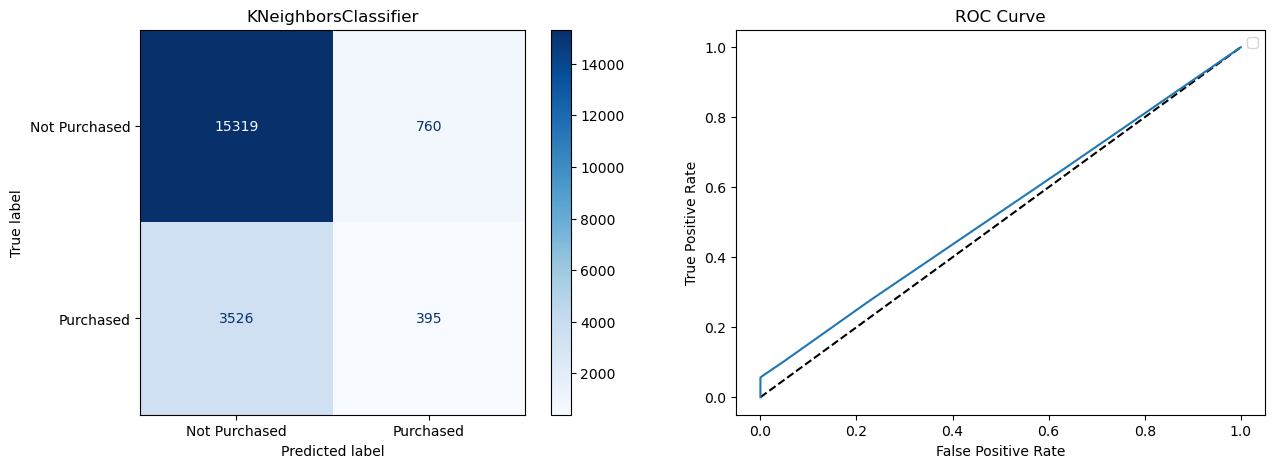

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.8149 
F1 Score:  0.10579710144927537 
ROC AUC:  0.5279265493496557


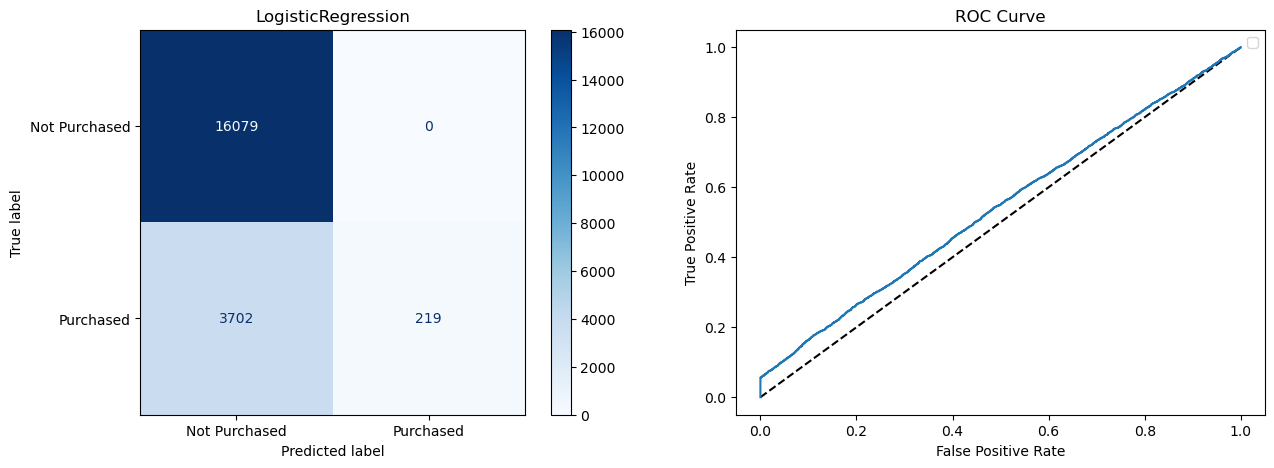

Accuracy:  0.80145 
F1 Score:  0.12973920666228358 
ROC AUC:  0.5269860975105399


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


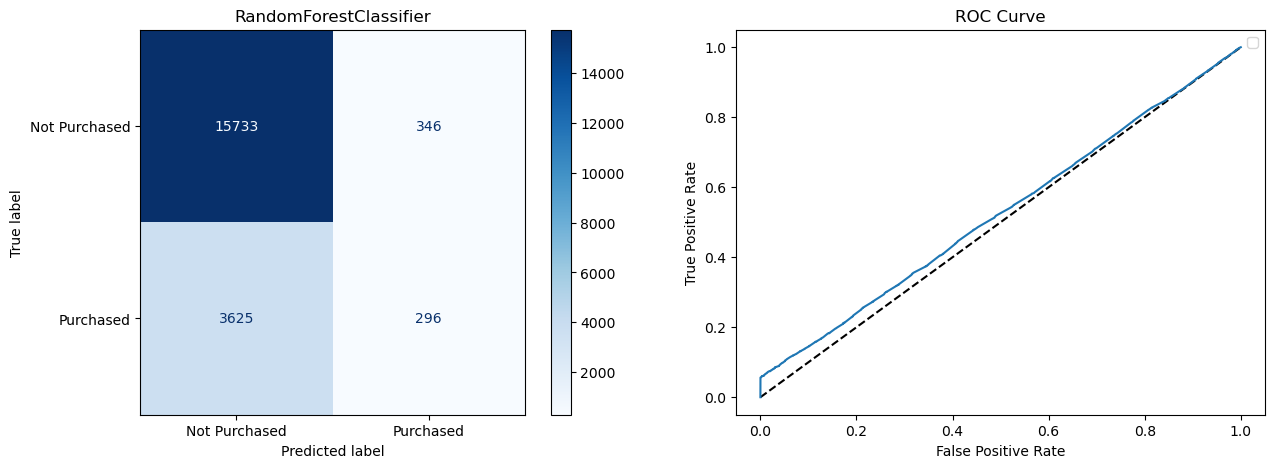

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.81435 
F1 Score:  0.1072373166626593 
ROC AUC:  0.5279701763920394


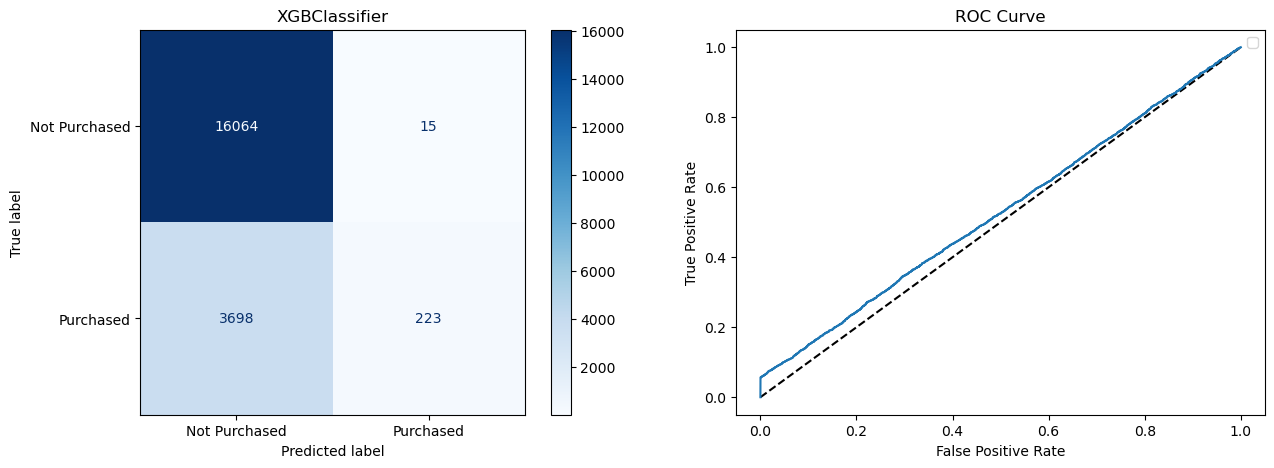

In [ ]:
for model in models:
    model_eval(model, X_train, X_test, y_train, y_test)

Its obvious from these initial results that the Accuracy is not a proper metric for evaluating our results. As we saw previously, the target values are imbalanced. The models, as they are, struggle with compensating for this imbalance, as we can see from the confusion matrices, as well as the roc-auc; the model is great at predicting the majority class, but fails in predicting well the minority class (purchased). Currently, the threshold value for the models sits at 0.5% probability. We can see from the roc score that we could just increase the desired True positive rate to get better results for consumers who purchased, however this would also significantly increase the False positive rate. This would be a "business decision".

The results of such a split are illustrated below:

              precision    recall  f1-score   support

           0       0.81      0.21      0.33     16079
           1       0.20      0.80      0.32      3921

    accuracy                           0.33     20000
   macro avg       0.51      0.51      0.33     20000
weighted avg       0.69      0.33      0.33     20000



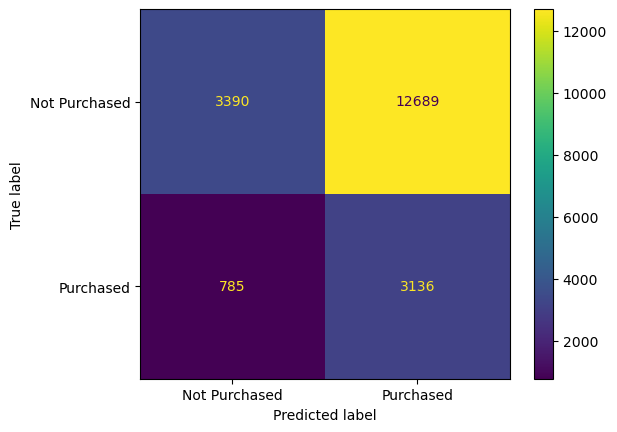

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
threshold = thresholds[np.argmin(np.abs(tpr-0.8))]
y_pred = np.where(y_pred_proba > threshold, 1, 0)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Not Purchased', 'Purchased']).plot()

Above, we can see that we "maximize" the True positives at the expense of the False positives, which in such a business setting would be acceptable-- we would rather not miss out on actual potential purchases, and maximize recall (true positive ratio)

The goal here though isn't to predict if a user will purchase or not purchase though, rather to see which email variant is most likely to get a user to purchase. That being said, we don't necessarily need a proper balance of True and False positives, rather a model which understands well the purchase habits of those who usually end up purchasing. A metric which could tell us this, is the roc_auc score. Therefore we will continue to try and create the "best model" we can with the previous objective of purchase vs. not purchased, with the end goal of choosing the best roc_auc score.

To try and imporve the models more, we will try various Over-sampling/Under-sampling techniques

### Random Under Sampling

Training set size: 30992
Accuracy:  0.6575 
F1 Score:  0.2635992259729091 
ROC AUC:  0.5271318725816276


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


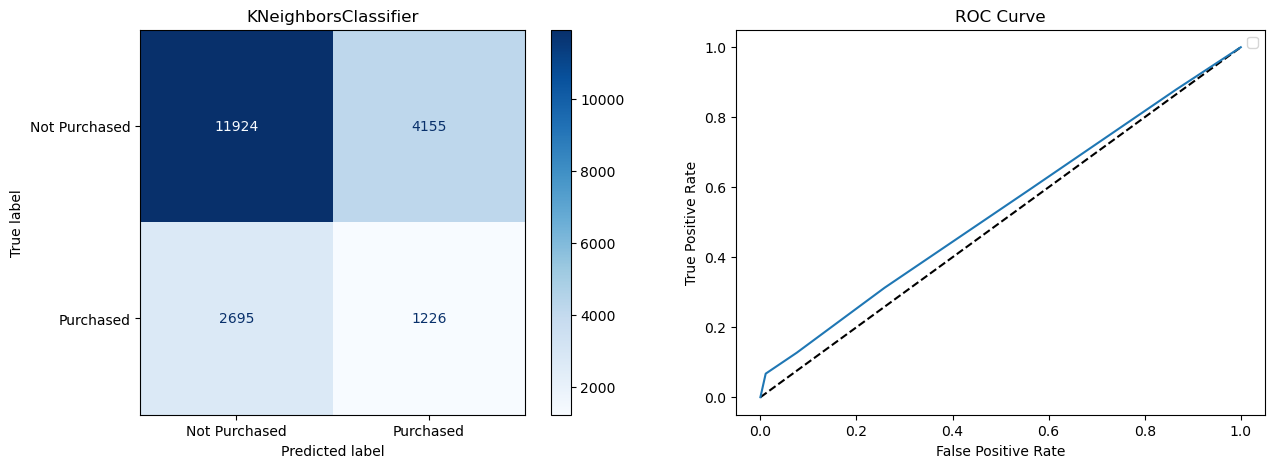

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.64775 
F1 Score:  0.27632254750898816 
ROC AUC:  0.5325422840892439


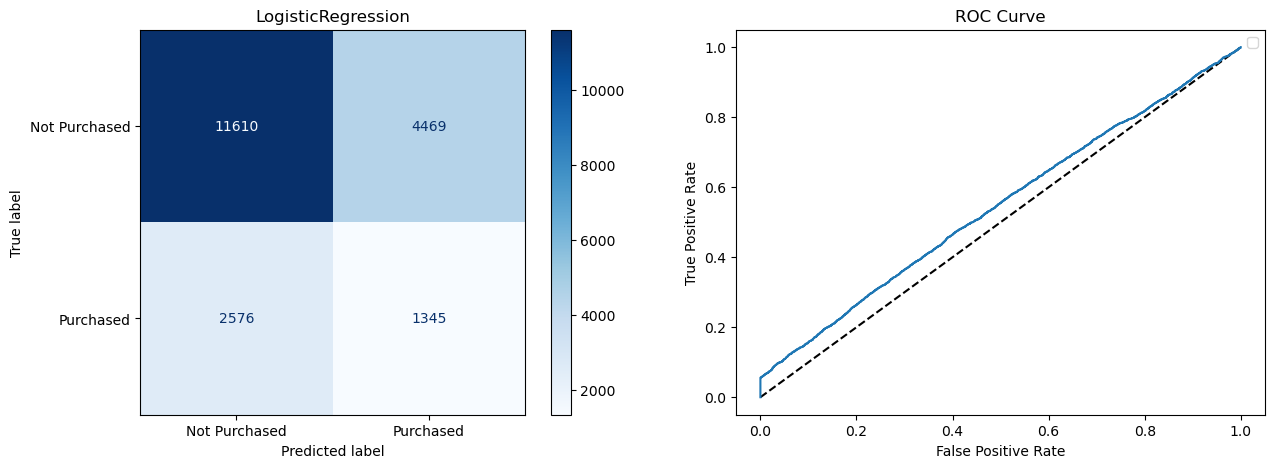

Accuracy:  0.5463 
F1 Score:  0.29242046163443536 
ROC AUC:  0.520551239616292


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


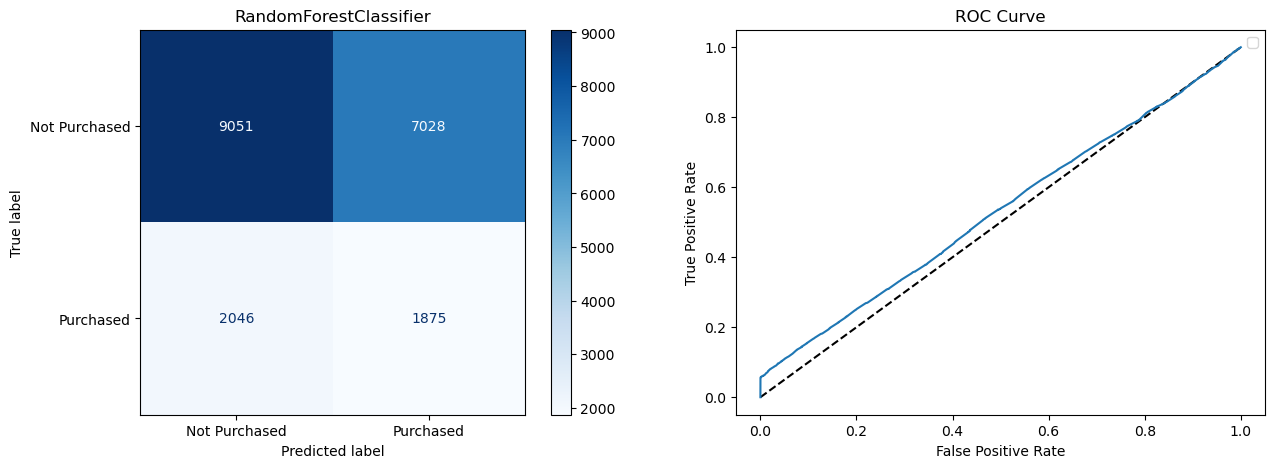

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.5482 
F1 Score:  0.2946135831381733 
ROC AUC:  0.5228899694902556


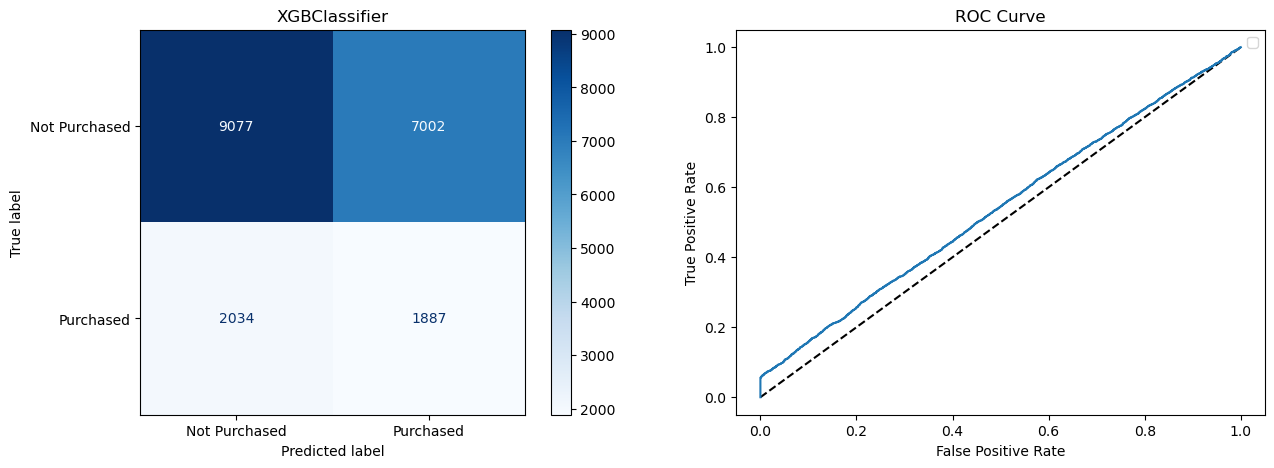

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train, )
print("Training set size:", len(X_rus))

for model in models:
    model_eval(model, X_rus, X_test, y_rus, y_test)

#### Oversampling with SMOTE

Training set size: 80000
Accuracy:  0.601 
F1 Score:  0.27109974424552424 
ROC AUC:  0.5168697548712198


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


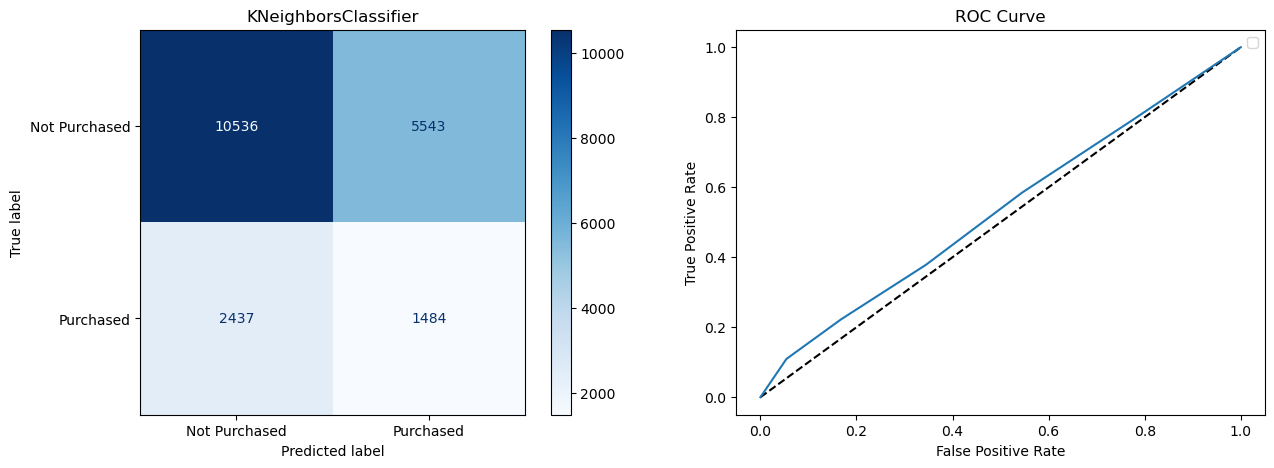

/home/shua/miniconda3/envs/lev_ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.8149 
F1 Score:  0.10579710144927537 
ROC AUC:  0.5279265493496557


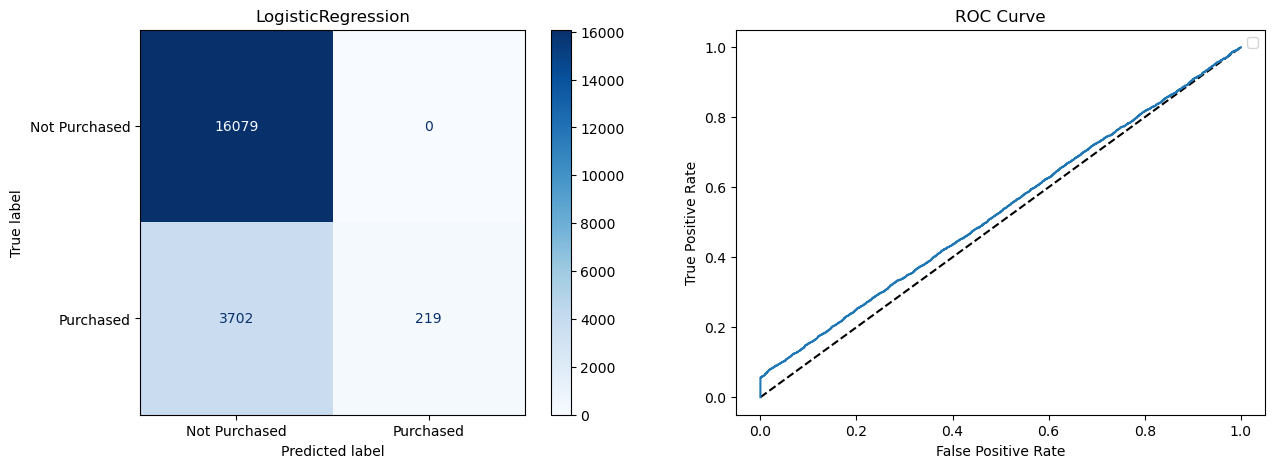

Accuracy:  0.79685 
F1 Score:  0.1404696424793738 
ROC AUC:  0.5275964161205514


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


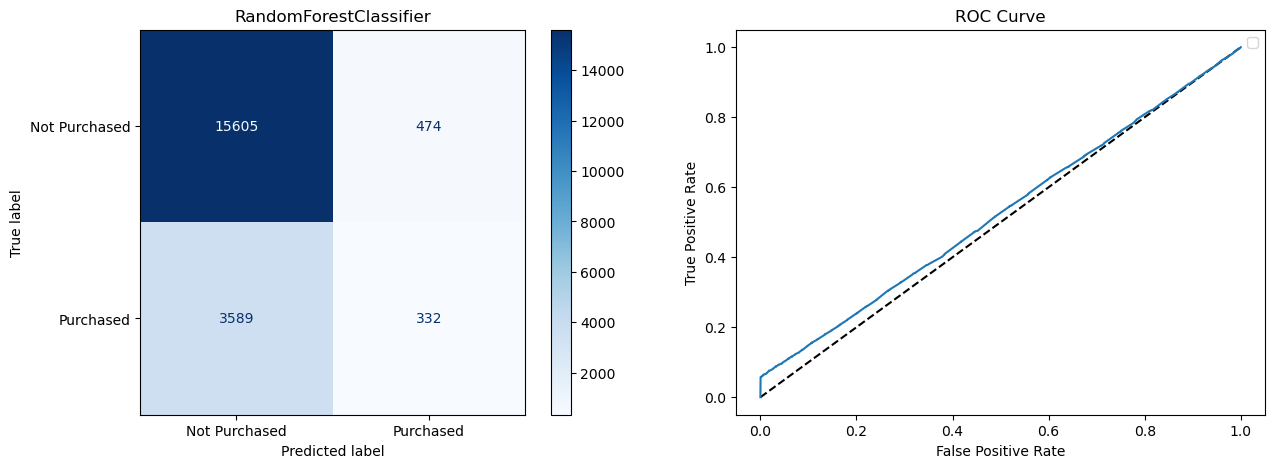

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.8143 
F1 Score:  0.10806916426512969 
ROC AUC:  0.5281319239887332


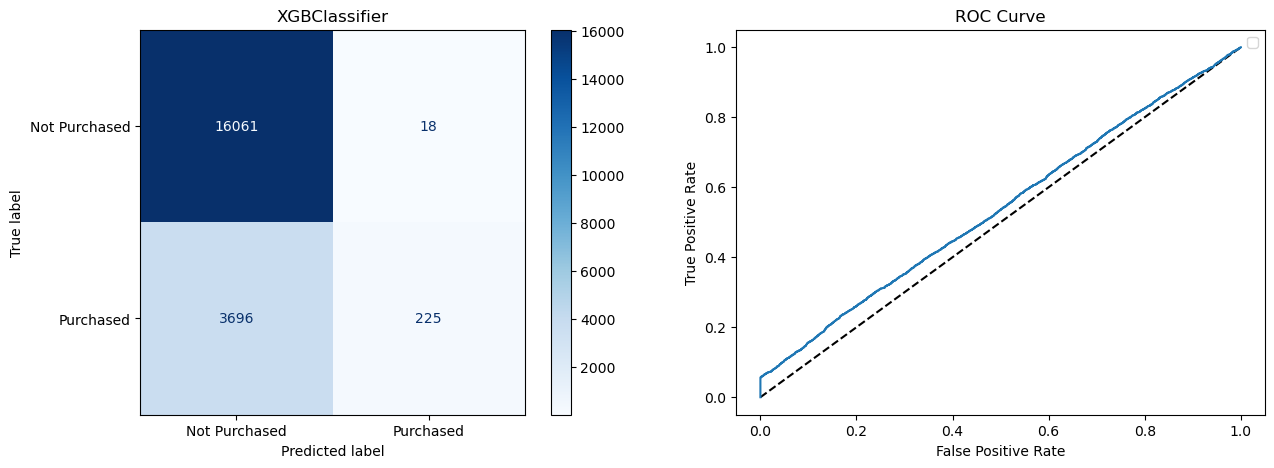

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", len(X_train))
x_smote, y_smote = smote.fit_resample(X_train, y_train)

for model in models:
    model_eval(model, x_smote, X_test, y_smote, y_test)

XGBoost with scale_pos_weight

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy:  0.6205 
F1 Score:  0.2757633587786259 
ROC AUC:  0.5252369156187017


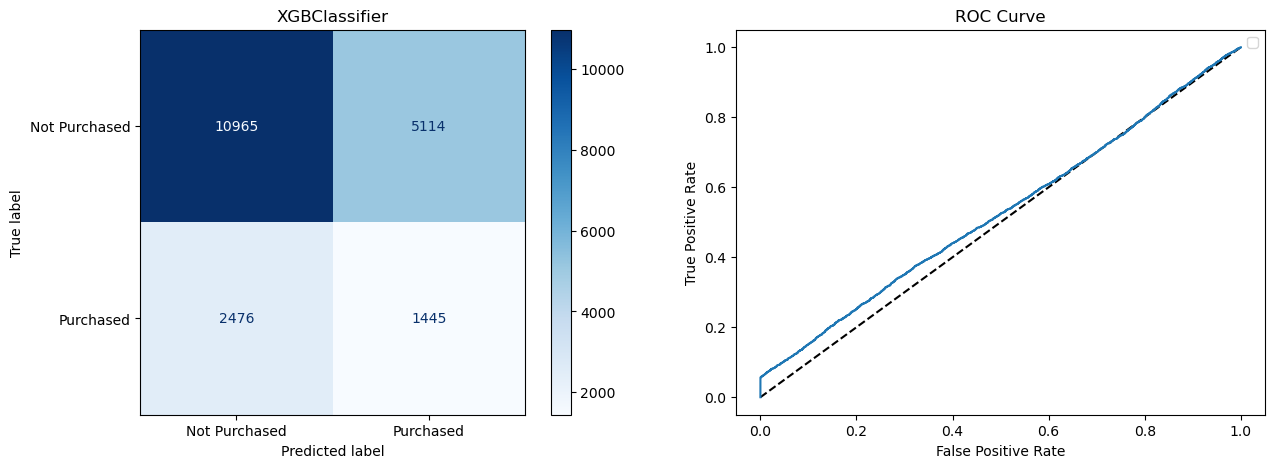

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=300, scale_pos_weight= y_train.value_counts()[0]/y_train.value_counts()[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

model_eval(xgb, X_train, X_test, y_train, y_test)

#### No improvements, now trying a hyperparameter search on xgboost to see if its a tuning issue.

Accuracy:  0.6625 
F1 Score:  0.2618110236220472 
ROC AUC:  0.5274452798641063


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


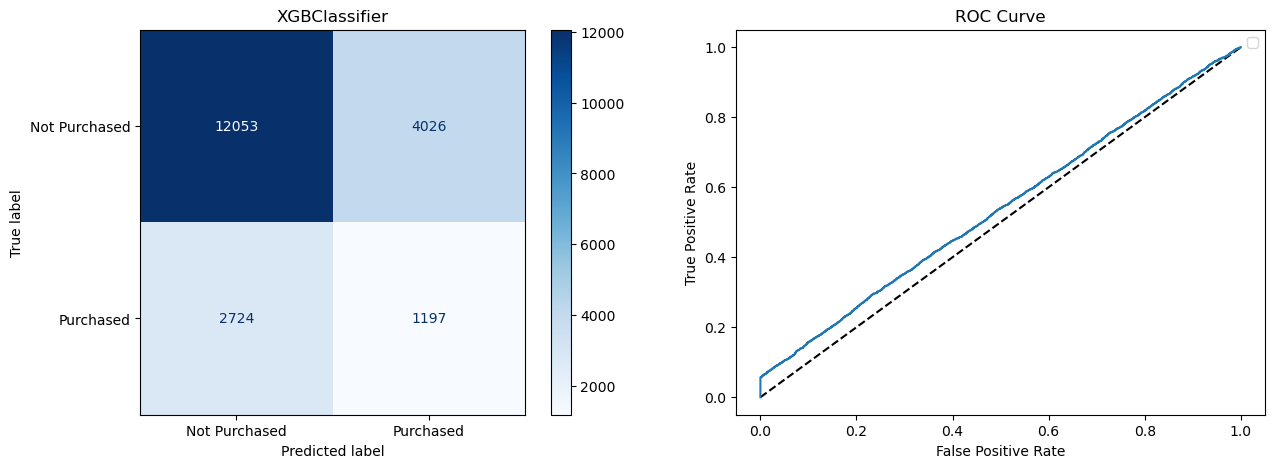

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
#fit model with best params from grid.best_params_
#small grid search for xgb
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100,300,500],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'scale_pos_weight': [2, y_train.value_counts()[0]/y_train.value_counts()[1], 10] #Using this to help scale the minority feature
                }
xgb = XGBClassifier()
grid = GridSearchCV(xgb, param_grid, cv=5, scoring= 'roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
model_eval(grid.best_estimator_, X_train, X_test, y_train, y_test)

After trying various sampling techniques, there weren't any drastic improvements in the models quality to compensate for the data imbalance.

However, as mentioned above, the model with the best roc_auc score to tell us which email variant gives the best odds of a customer purchasing the product. Also, the xgboost model after the grid search seems to be able to learn the purchases more than most of the other models, without too many false positives.

In [ ]:
feature_importances = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


<AxesSubplot: >

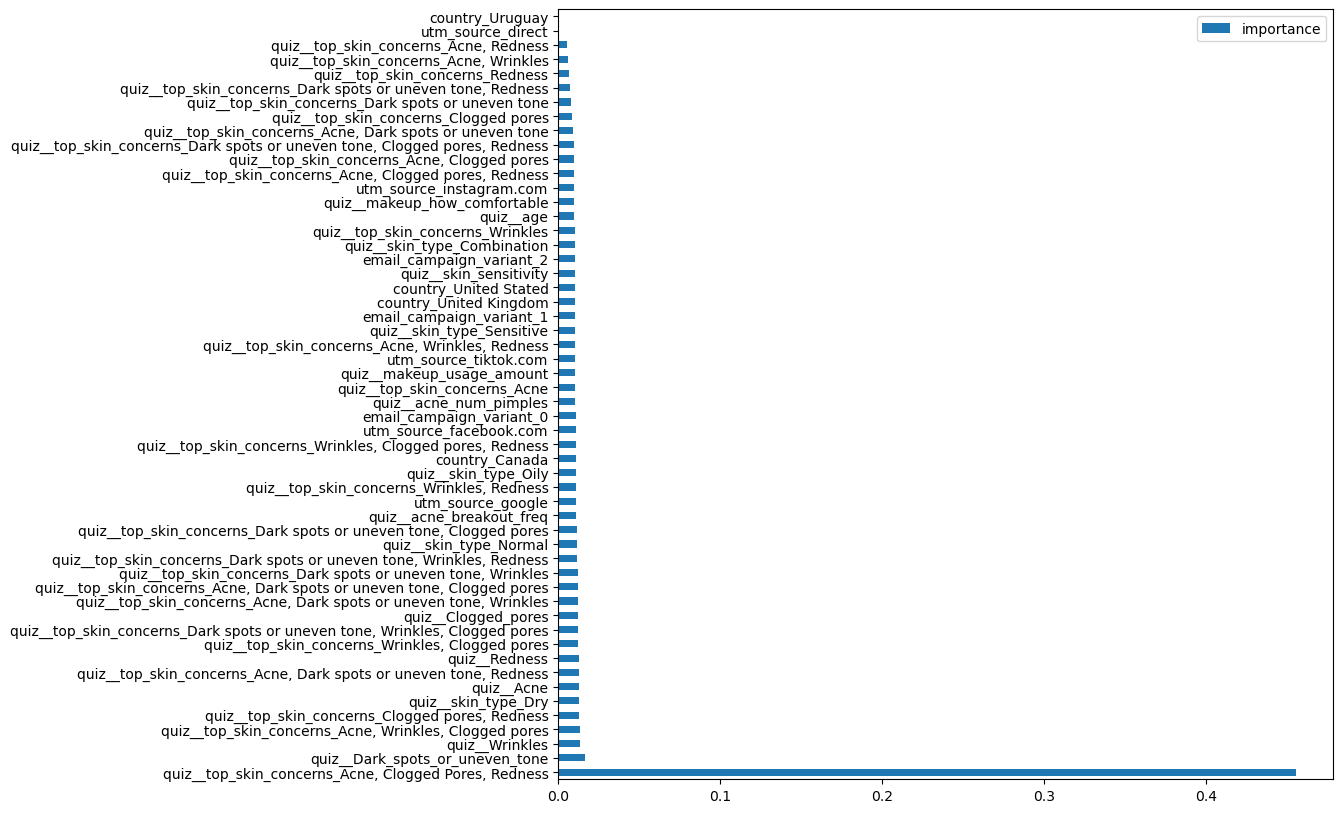

In [ ]:
feature_importances.plot(kind='barh', figsize=(10,10))

In [ ]:
#function to change the values of the email_variant columns, to try each combination and see which has the highest probability of purchase
def email_variant_selection(sample, model):
    results = {}
    columns = ['email_campaign_variant_0', 'email_campaign_variant_1', 'email_campaign_variant_2']
    for i, column in enumerate(columns):
        sample[column] = 1
        #make other email columns 0
        for col in columns:
            if col != column:
                sample[col] = 0
                #predict the probability of purchase
        prob = model.predict_proba(sample)[:,1]
        results[column] = prob[0] #prob 1?
    print("results" , results)
    print("Chosen Email Variant:", max(results, key=results.get))
    return results

results {'email_campaign_variant_0': 0.17375778, 'email_campaign_variant_1': 0.1696203, 'email_campaign_variant_2': 0.1634096}
Chosen Email Variant: email_campaign_variant_0


In [ ]:
example = X_test[y_test == 1].sample(1)
email = email_variant_selection(example, xgb)


results {'email_campaign_variant_0': 0.18860231, 'email_campaign_variant_1': 0.22300106, 'email_campaign_variant_2': 0.21557742}
Chosen Email Variant: email_campaign_variant_1
